<a href="https://colab.research.google.com/github/algosipdahack/DDoS_attack_detect/blob/main/project_finish_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

필요한 모듈 불러오기

In [1]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install import_ipynb
import import_ipynb
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Masking, Bidirectional,Conv1D, MaxPooling1D
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 8.5 MB/s 


구글 드라이브에 데이터 파일을 올려놓은 뒤 드라이브와 코랩의 연동을 통해 데이터를 로드

In [2]:
from google.colab import drive
drive.mount('/content/drive')#구글 드라이브와 mount

Mounted at /content/drive


데이터 로드

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

benign_path = "/content/drive/MyDrive/information_system/normal/"
malicious_path = "/content/drive/MyDrive/information_system/malicious/"

benign=[]
for i in range(5):
    benign.append(pd.read_csv(benign_path+'network_benign_training_set_'+str(i).zfill(2)+'.csv',error_bad_lines=False))
malicious=pd.read_csv(malicious_path+'network_malicious_training_set.csv',error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (12,13,14,15,16,18,19,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


전처리

In [4]:
import datetime
for i in range(5):
  # Time 속성 전처리
  benign[i]['_ws.col.UTCtime'] = pd.to_datetime(benign[i]['_ws.col.UTCtime'])
  # 각 CSV 파일마다 time의 단위를 utc time -> 밀리초 단위로 변환
  benign[i]['_ws.col.UTCtime'] = benign[i]['_ws.col.UTCtime'].astype(np.int64)//10**9
  # 한 엑셀 파일 당 처음 밀리초를 0부터 시작하게 만듦
  benign[i]['_ws.col.UTCtime'] = benign[i]['_ws.col.UTCtime'] - benign[i].iloc[0,0]
  
  # 열자르기
  benign[i] = benign[i].loc[:,"_ws.col.UTCtime":"tcp.ack"]
  benign[i] = benign[i].dropna(axis=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  


In [5]:
malicious['_ws.col.UTCtime'] = pd.to_datetime(malicious['_ws.col.UTCtime'])
malicious['_ws.col.UTCtime'] = malicious['_ws.col.UTCtime'].astype(np.int64)//10**9
malicious['_ws.col.UTCtime'] = malicious['_ws.col.UTCtime'] - malicious.iloc[0,0]

malicious = malicious.loc[:,"_ws.col.UTCtime":"tcp.ack"]
malicious = malicious.dropna(axis=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  


각 속성값 정의

In [6]:
for i in range(len(benign)):
    benign[i] = benign[i].astype({"_ws.col.UTCtime":'int','tcp.srcport': 'int','tcp.dstport': 'int','tcp.len': 'int','tcp.seq':'int','tcp.ack': 'int'})
malicious = malicious.astype({"_ws.col.UTCtime":'int','tcp.srcport': 'int','tcp.dstport': 'int','tcp.len': 'int','tcp.seq':'int','tcp.ack': 'int'})

In [7]:
#benign data를 그룹핑하고 100개가 넘는 그룹을 골라내기
groupset=[]
over_100_group=[]
for i in range(len(benign)):
    gb = benign[i].groupby(['_ws.col.Protocol','ip.src','ip.dst','tcp.srcport'])
    for key, group in gb:
        group = np.asarray(group)
        if len(group) > 100:
            over_100_group.append(group)
        else :
            groupset.append(group)

In [8]:
#benign data 100개가 넘는 그룹 100개씩 잘라서 그룹셋에 넣기
for i in range(len(over_100_group)):
    for j in range(0,len(over_100_group[i]),100):
        groupset.append(over_100_group[i][j:j+100])

In [9]:
len(groupset)
groupset

[array([[317, 'DCERPC', '192.168.10.12', '192.168.10.25', 139, 49164, 128,
         485, 717],
        [498, 'DCERPC', '192.168.10.12', '192.168.10.25', 139, 49165, 128,
         485, 717],
        [676, 'DCERPC', '192.168.10.12', '192.168.10.25', 139, 49166, 128,
         485, 717],
        [896, 'DCERPC', '192.168.10.12', '192.168.10.25', 139, 49171, 128,
         485, 717],
        [1077, 'DCERPC', '192.168.10.12', '192.168.10.25', 139, 49172,
         128, 485, 717],
        [1256, 'DCERPC', '192.168.10.12', '192.168.10.25', 139, 49264,
         128, 485, 717]], dtype=object),
 array([[428, 'DCERPC', '192.168.10.14', '192.168.10.3', 49414, 135, 116,
         1, 1]], dtype=object),
 array([[428, 'DCERPC', '192.168.10.14', '192.168.10.3', 49415, 49666,
         1749, 1, 1],
        [428, 'DCERPC', '192.168.10.14', '192.168.10.3', 49415, 49666,
         220, 1750, 261],
        [428, 'DCERPC', '192.168.10.14', '192.168.10.3', 49415, 49666,
         1705, 2598, 1010],
        [428, 'DC

In [10]:
for i in range(len(groupset)):
    groupset[i][:,0] = groupset[i][:,0] - groupset[i][0][0]

In [11]:
X=[]
for i in range(len(groupset)):
    # 각 groupset들의 헤더 제거
    temp = np.delete(groupset[i],[1,2,3,4,5],1)
    num = 100 - len(temp)
    # -1로 패딩
    X.append(np.pad(temp,((0,num),(0,0)),'constant', constant_values=-1))

X_data로 변환

In [12]:
X_data=np.asarray(X)

In [13]:
len(X_data)

79355

Y_data(라벨 생성)

In [14]:
Y_data=[]
for i in range(len(X_data)):
    # 정상 데이터 이므로 => 0
    Y_data.append(0)

In [15]:
len(Y_data)

79355

In [16]:
X_data.shape

(79355, 100, 4)

공격데이터

In [17]:
groupset_a=[]
over_100_group_a=[]
gb = malicious.groupby(['_ws.col.Protocol','ip.src','ip.dst','tcp.srcport'])
for key, group in gb:
    group = np.asarray(group)
    if len(group)>100:
        over_100_group_a.append(group)
    else :
        groupset_a.append(group)


In [18]:
for i in range(len(over_100_group_a)):
    for j in range(0,len(over_100_group_a[i]),100):
        groupset_a.append(over_100_group_a[i][j:j+100])

In [19]:
for i in range(len(groupset_a)):
    groupset_a[i][:,0]=groupset_a[i][:,0]-groupset_a[i][0][0]

In [20]:
X_a=[]
for i in range(len(groupset_a)):
    temp = np.delete(groupset_a[i],[1,2,3,4,5],1)
    num=100-len(temp)
    X_a.append(np.pad(temp,((0,num),(0,0)),'constant', constant_values=-1))

In [21]:
Y_a=[]
for i in range(len(X_a)):
    Y_a.append(1)

In [22]:
X_attack_data=np.asarray(X_a)
Y_attack_data=np.asarray(Y_a)

전체 data

In [23]:
X_total=np.concatenate((X_data,X_attack_data), axis=0)
#index : 0~891936 까지 normal, 총 891937

In [24]:
X_total.shape

(79536, 100, 4)

In [25]:
Y_total=np.concatenate((Y_data,Y_attack_data), axis=0)

In [26]:
Y_total.shape

(79536,)

In [27]:
# Conv1d 모델을 이용해 특징 맵 추출 후 가중치 부여, LSTM 단일 은닉층을 배치.
def build_model():
    learning_rate = 0.00001
    seq_length = 100
    data_dim = 4
    METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy')
    ]
    model = Sequential()

    model.add(Conv1D(256, 3, activation = 'relu', kernel_regularizer='l2', input_shape=(100, 4)))
    model.add(MaxPooling1D(pool_size=4))    
    model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
    model.add(LSTM(256))  
    model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
    
    model.add(Dense(1, activation='sigmoid', kernel_regularizer='l2'))

    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=METRICS)
    
    return model

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

  교차 검증 사용


In [29]:
skf = StratifiedKFold(n_splits = 10)
k = 10

In [30]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

In [31]:
all_history=[]
all_acc=[]
all_f1=[]
matrix=[]

model =  build_model()
for train_index, test_index in skf.split(X_total,Y_total):
    X_train = X_total[train_index]
    y_train = Y_total[train_index]  
    X_test = X_total[test_index]
    y_test = Y_total[test_index]

    sm = SMOTE()
    # smote 적용시키기 위해 2차원 배열로 변환
    X_train=np.reshape(X_train,(len(X_train),400))
    # smote 사용 -> 데이터 불균형 해소
    X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)

    # 다시 reshape로 3차원으로 변경
    X_train_oversampled = np.reshape(X_train_oversampled,(len(X_train_oversampled),100,4))
    history = model.fit(X_train_oversampled, y_train_oversampled,epochs=10, batch_size=256, verbose=1)
    
    all_history.append(history.history)
    X_test = X_test.astype('float32')
    y_pred = model.predict(X_test)
    y_pred_binary = np.around(y_pred)
    
    acc = accuracy_score(y_test, y_pred_binary)
    all_acc.append(acc)
    
    f1=f1_score(y_test, y_pred_binary)
    all_f1.append(f1)
    
    matrix.append(confusion_matrix(y_test, y_pred_binary))
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
    
    print(f'Accuracy: {acc}')
    print(f'f-score: {f1}')
    print(f'tn fp fn tp :{tn, fp, fn, tp}')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
558/558 [==============================] - 277s 492ms/step - loss: 3.7926 - accuracy: 0.8659
Epoch 2/10
558/558 [==============================] - 248s 445ms/step - loss: 3.1799 - accuracy: 0.9987
Epoch 3/10
558/558 [==============================] - 248s 444ms/step - loss: 2.9100 - accuracy: 0.9996
Epoch 4/10
558/558 [==============================] - 248s 445ms/step - loss: 2.6726 - accuracy: 0.9997
Epoch 5/10
558/558 [==============================] - 248s 444ms/step - loss: 2.4538 - accuracy: 0.9998
Epoch 6/10
558/558 [==============================] - 248s 445ms/step - loss: 2.2492 - accuracy: 0.9998
Epoch 7/10
558/558 [==============================] - 248s 444ms/step - loss: 2.0584 - accuracy: 0.9999
Epoch 8/10
558/558 [==============================] - 249s 446ms/step - loss: 1.8814 - accuracy: 0.9999
Epoch 9/10
558/558 [==============================] - 248s 444ms/step - loss: 1.7186 - accuracy: 0.9999
Epoch 10/10
558/558 [==============================] - 250s 448m

In [32]:
print(all_acc)
print(all_f1)
for i in range(k):
    print(matrix[i][0][0],matrix[i][0][1],matrix[i][1][0],matrix[i][1][1])

[0.9996228312798592, 0.9988684938395775, 0.9997485541865728, 1.0, 0.9994971083731455, 1.0, 1.0, 1.0, 1.0, 0.9994970451401987]
[0.923076923076923, 0.8, 0.9473684210526316, 1.0, 0.8750000000000001, 1.0, 1.0, 1.0, 1.0, 0.8750000000000001]
7933 3 0 18
7927 9 0 18
7934 2 0 18
7936 0 0 18
7936 0 4 14
7935 0 0 19
7935 0 0 18
7935 0 0 18
7935 0 0 18
7935 0 4 14


In [33]:
print(sum(all_acc)/10)
print(sum(all_f1)/10)
for i in range(k):
    print(matrix[i][0][0],matrix[i][0][1],matrix[i][1][0],matrix[i][1][1])

0.9997234032819353
0.9420445344129554
7933 3 0 18
7927 9 0 18
7934 2 0 18
7936 0 0 18
7936 0 4 14
7935 0 0 19
7935 0 0 18
7935 0 0 18
7935 0 0 18
7935 0 4 14


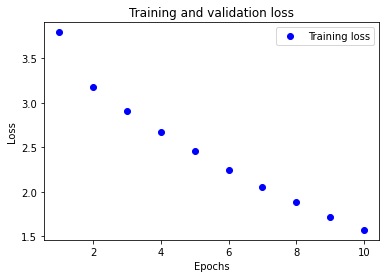

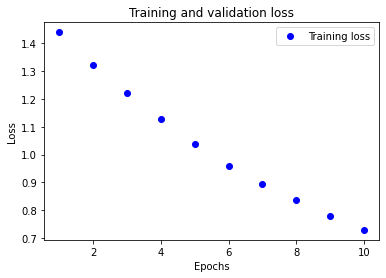

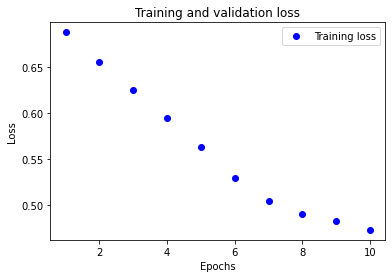

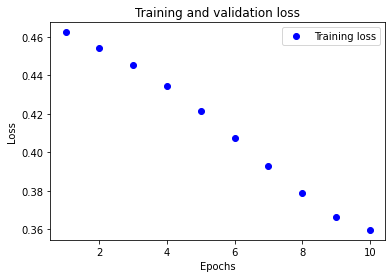

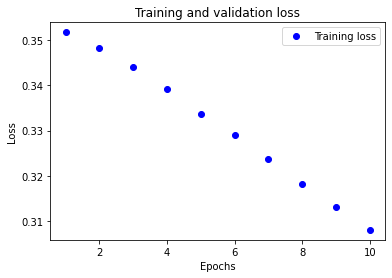

In [34]:
for i in range(5):
    loss =all_history[i]['loss']
    #val_loss = all_history[i]['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')  # ‘bo’는 파란색 점을 의미합니다.
    #plt.plot(epochs, val_loss, 'b', label='Validation loss') # ‘b’는 파란색 실선을 의미합니다.
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()